**Customizing SGD and ADAM optimizers**


---


Custom version of the optimizers code from Pytorch by adding a multiple of the loss in each step along with the gradient. Thus, a vanilla step of w = w - lr * grad is changed to w = w - lr * loss * grad
The idea is to pump up the gradient step when the loss is high and dampen it when the loss is low. It should help to raise the gradient-step for higher loss values even if the gradient itself is low.
Experiments on a simple CNN and CIFAR10.
Need to add experiments tracking / viz (Tensorboard) to properly compare experiments.

In [161]:
SEED = 210
torch.manual_seed(SEED)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [226]:
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from typing import List, Optional


class LossSGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

        Use loss * grad instead of just grad. Keeps stepsize high enough when loss is high, even if gradient is low
    """

    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize=False, foreach: Optional[bool] = None):

        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        maximize=maximize, foreach=foreach)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(LossSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)

    @torch.no_grad()
    def step(self, sgdloss,closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
      
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            has_sparse_grad = False

            for p in group['params']:
                if p.grad is not None:

                    # print(F'Loss: {sgdloss}, p.grad: {p.grad}, Sign: {torch.sign(p.grad)}')
                    p.grad = sgdloss * p.grad
                    
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)
                    if p.grad.is_sparse:
                        has_sparse_grad = True

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            sgd(params_with_grad,
                d_p_list,
                momentum_buffer_list,
                weight_decay=group['weight_decay'],
                momentum=group['momentum'],
                lr=group['lr'],
                dampening=group['dampening'],
                nesterov=group['nesterov'],
                maximize=group['maximize'],
                has_sparse_grad=has_sparse_grad,
                foreach=group['foreach'])

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss


def sgd(params: List[Tensor],
        d_p_list: List[Tensor],
        momentum_buffer_list: List[Optional[Tensor]],
        # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
        # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
        has_sparse_grad: bool = None,
        foreach: bool = None,
        *,
        weight_decay: float,
        momentum: float,
        lr: float,
        dampening: float,
        nesterov: bool,
        maximize: bool):
    r"""Functional API that performs SGD algorithm computation.

    See :class:`~torch.optim.SGD` for details.
    """

    if foreach is None:
        # Placeholder for more complex foreach logic to be added when value is not set
        foreach = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')

    if foreach and not torch.jit.is_scripting():
        func = _multi_tensor_sgd
    else:
        func = _single_tensor_sgd

    func(params,
         d_p_list,
         momentum_buffer_list,
         weight_decay=weight_decay,
         momentum=momentum,
         lr=lr,
         dampening=dampening,
         nesterov=nesterov,
         has_sparse_grad=has_sparse_grad,
         maximize=maximize)

def _single_tensor_sgd(params: List[Tensor],
                       d_p_list: List[Tensor],
                       momentum_buffer_list: List[Optional[Tensor]],
                       *,
                       weight_decay: float,
                       momentum: float,
                       lr: float,
                       dampening: float,
                       nesterov: bool,
                       maximize: bool,
                       has_sparse_grad: bool):

    for i, param in enumerate(params):

        d_p = d_p_list[i]
        if weight_decay != 0:
            d_p = d_p.add(param, alpha=weight_decay)

        if momentum != 0:
            buf = momentum_buffer_list[i]

            if buf is None:
                buf = torch.clone(d_p).detach()
                momentum_buffer_list[i] = buf
            else:
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)

            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        alpha = lr if maximize else -lr
        param.add_(d_p, alpha=alpha)


def _multi_tensor_sgd(params: List[Tensor],
                      grads: List[Tensor],
                      momentum_buffer_list: List[Optional[Tensor]],
                      *,
                      weight_decay: float,
                      momentum: float,
                      lr: float,
                      dampening: float,
                      nesterov: bool,
                      maximize: bool,
                      has_sparse_grad: bool):

    if len(params) == 0:
        return

    if has_sparse_grad is None:
        has_sparse_grad = any([grad.is_sparse for grad in grads])

    if weight_decay != 0:
        grads = torch._foreach_add(grads, params, alpha=weight_decay)

    if momentum != 0:
        bufs = []

        all_states_with_momentum_buffer = True
        for i in range(len(momentum_buffer_list)):
            if momentum_buffer_list[i] is None:
                all_states_with_momentum_buffer = False
                break
            else:
                bufs.append(momentum_buffer_list[i])

        if all_states_with_momentum_buffer:
            torch._foreach_mul_(bufs, momentum)
            torch._foreach_add_(bufs, grads, alpha=1 - dampening)
        else:
            bufs = []
            for i in range(len(momentum_buffer_list)):
                if momentum_buffer_list[i] is None:
                    buf = momentum_buffer_list[i] = torch.clone(grads[i]).detach()
                else:
                    buf = momentum_buffer_list[i]
                    buf.mul_(momentum).add_(grads[i], alpha=1 - dampening)

                bufs.append(buf)

        if nesterov:
            torch._foreach_add_(grads, bufs, alpha=momentum)
        else:
            grads = bufs

    alpha = lr if maximize else -lr
    if not has_sparse_grad:
        torch._foreach_add_(params, grads, alpha=alpha)
    else:
        # foreach APIs dont support sparse
        for i in range(len(params)):
            params[i].add_(grads[i], alpha=alpha)

In [3]:
#import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [39]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

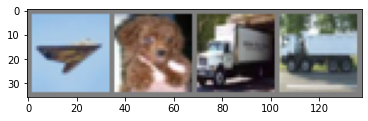

plane dog   truck truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
       # self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
       # self.conv4 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 10)
    

    def forward(self, x):
      #  x = self.pool(F.relu(self.conv2(F.relu(self.conv1(x)))))
      #  x = self.pool(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
 #       x = self.fc3(x)
        return x




Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [117]:
net = Net()

net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [118]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [119]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 500 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 2.291
[1,   100] loss: 2.189
[1,   150] loss: 2.132
[1,   200] loss: 2.161
[1,   250] loss: 2.159
[1,   300] loss: 2.127
[1,   350] loss: 2.078
[1,   400] loss: 2.123
[1,   450] loss: 2.039
[1,   500] loss: 1.999
[1,   550] loss: 2.005
[1,   600] loss: 1.952
[1,   650] loss: 1.892
[1,   700] loss: 1.858
[1,   750] loss: 1.899
[1,   800] loss: 1.778
[1,   850] loss: 1.769
[1,   900] loss: 1.681
[1,   950] loss: 1.545
[1,  1000] loss: 1.569
[1,  1050] loss: 1.519
[1,  1100] loss: 1.484
[1,  1150] loss: 1.520
[1,  1200] loss: 1.482
[1,  1250] loss: 1.486
[1,  1300] loss: 1.432
[1,  1350] loss: 1.384
[1,  1400] loss: 1.424
[1,  1450] loss: 1.433
[1,  1500] loss: 1.361
[1,  1550] loss: 1.469
[1,  1600] loss: 1.372
[1,  1650] loss: 1.348
[1,  1700] loss: 1.319
[1,  1750] loss: 1.331
[1,  1800] loss: 1.420
[1,  1850] loss: 1.251
[1,  1900] loss: 1.296
[1,  1950] loss: 1.293
[1,  2000] loss: 1.201
[1,  2050] loss: 1.234
[1,  2100] loss: 1.282
[1,  2150] loss: 1.290
[1,  2200] 

[1,  2000] loss: 2.227
[1,  4000] loss: 1.965
[1,  6000] loss: 1.707
[1,  8000] loss: 1.555
[1, 10000] loss: 1.470
[1, 12000] loss: 1.388
Finished Training

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the training images: {100 * correct // total} %')

Accuracy of the network on the training images: 67 %


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


LOSS SGD TRIALS

================

In [227]:


lossnet = Net()

lossnet.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [228]:
loptimizer = LossSGD(lossnet.parameters(), lr=0.005, momentum=0.9)

In [229]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # while i<=2500: #overfiting a batch
          # zero the parameter gradients
      loptimizer.zero_grad()

      # forward + backward + optimize
      outputs = lossnet(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      loptimizer.step(loss)
      # print(F'Loss: {loss}')
      # print statistics
      running_loss += loss.item()
      if i % 50 == 49:    # print every 500 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
          running_loss = 0.0
          
      #     i += 1
      # break

print('Finished Training')

[1,    50] loss: 2.298
[1,   100] loss: 2.247
[1,   150] loss: 2.113
[1,   200] loss: 2.065
[1,   250] loss: 1.995
[1,   300] loss: 1.867
[1,   350] loss: 1.844
[1,   400] loss: 1.821
[1,   450] loss: 1.737
[1,   500] loss: 1.711
[1,   550] loss: 1.624
[1,   600] loss: 1.660
[1,   650] loss: 1.573
[1,   700] loss: 1.534
[1,   750] loss: 1.563
[1,   800] loss: 1.514
[1,   850] loss: 1.441
[1,   900] loss: 1.427
[1,   950] loss: 1.420
[1,  1000] loss: 1.493
[1,  1050] loss: 1.388
[1,  1100] loss: 1.421
[1,  1150] loss: 1.426
[1,  1200] loss: 1.404
[1,  1250] loss: 1.439
[1,  1300] loss: 1.393
[1,  1350] loss: 1.435
[1,  1400] loss: 1.362
[1,  1450] loss: 1.325
[1,  1500] loss: 1.267
[1,  1550] loss: 1.374
[1,  1600] loss: 1.320
[1,  1650] loss: 1.387
[1,  1700] loss: 1.317
[1,  1750] loss: 1.258
[1,  1800] loss: 1.262
[1,  1850] loss: 1.298
[1,  1900] loss: 1.293
[1,  1950] loss: 1.267
[1,  2000] loss: 1.243
[1,  2050] loss: 1.313
[1,  2100] loss: 1.187
[1,  2150] loss: 1.281
[1,  2200] 

In [181]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = lossnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the training images: {100 * correct // total} %')

Accuracy of the network on the training images: 87 %


In [182]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = lossnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 73 %


===========================







LOSS ADAM TRIALS

==================

In [183]:
import math
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from typing import List, Optional


class LossAdam(Optimizer):
    r"""Implements Adam algorithm.

    .. math::
       \begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
                \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
            &\hspace{13mm}      \lambda \text{ (weight decay)},  \: \textit{amsgrad},
                \:\textit{maximize}                                                              \\
            &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
                v_0\leftarrow 0 \text{ (second moment)},\: \widehat{v_0}^{max}\leftarrow 0\\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\

            &\hspace{5mm}\textbf{if} \: \textit{maximize}:                                       \\
            &\hspace{10mm}g_t           \leftarrow   -\nabla_{\theta} f_t (\theta_{t-1})         \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})          \\
            &\hspace{5mm}\textbf{if} \: \lambda \neq 0                                           \\
            &\hspace{10mm} g_t \leftarrow g_t + \lambda  \theta_{t-1}                            \\
            &\hspace{5mm}m_t           \leftarrow   \beta_1 m_{t-1} + (1 - \beta_1) g_t          \\
            &\hspace{5mm}v_t           \leftarrow   \beta_2 v_{t-1} + (1-\beta_2) g^2_t          \\
            &\hspace{5mm}\widehat{m_t} \leftarrow   m_t/\big(1-\beta_1^t \big)                   \\
            &\hspace{5mm}\widehat{v_t} \leftarrow   v_t/\big(1-\beta_2^t \big)                   \\
            &\hspace{5mm}\textbf{if} \: amsgrad                                                  \\
            &\hspace{10mm}\widehat{v_t}^{max} \leftarrow \mathrm{max}(\widehat{v_t}^{max},
                \widehat{v_t})                                                                   \\
            &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}^{max}} + \epsilon \big)                                 \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}} + \epsilon \big)                                       \\
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}

    For further details regarding the algorithm we refer to `Adam: A Method for Stochastic Optimization`_.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        foreach (bool, optional): whether foreach implementation of optimizer
            is used (default: None)
        maximize (bool, optional): maximize the params based on the objective, instead of
            minimizing (default: False)

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, *, foreach: Optional[bool] = None,
                 maximize: bool = False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        maximize=maximize, foreach=foreach)
        super(LossAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))

    @torch.no_grad()
    def step(self, gdloss, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:

                    p.grad = gdloss * p.grad

                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = torch.tensor(0.)
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'],
                 maximize=group['maximize'],
                 foreach=group['foreach'])

        return loss


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[Tensor],
         # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
         # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
         foreach: bool = None,
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float,
         maximize: bool):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    if not all([isinstance(t, torch.Tensor) for t in state_steps]):
        raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")

    if foreach is None:
        # Placeholder for more complex foreach logic to be added when value is not set
        foreach = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')

    if foreach and not torch.jit.is_scripting():
        func = _multi_tensor_adam
    else:
        func = _single_tensor_adam

    func(params,
         grads,
         exp_avgs,
         exp_avg_sqs,
         max_exp_avg_sqs,
         state_steps,
         amsgrad=amsgrad,
         beta1=beta1,
         beta2=beta2,
         lr=lr,
         weight_decay=weight_decay,
         eps=eps,
         maximize=maximize)


def _single_tensor_adam(params: List[Tensor],
                        grads: List[Tensor],
                        exp_avgs: List[Tensor],
                        exp_avg_sqs: List[Tensor],
                        max_exp_avg_sqs: List[Tensor],
                        state_steps: List[Tensor],
                        *,
                        amsgrad: bool,
                        beta1: float,
                        beta2: float,
                        lr: float,
                        weight_decay: float,
                        eps: float,
                        maximize: bool):

    for i, param in enumerate(params):

        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step_t = state_steps[i]
        # update step
        step_t += 1
        step = step_t.item()

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)



        step_size = lr / bias_correction1
        param.addcdiv_(exp_avg, denom, value=-step_size)


def _multi_tensor_adam(params: List[Tensor],
                       grads: List[Tensor],
                       exp_avgs: List[Tensor],
                       exp_avg_sqs: List[Tensor],
                       max_exp_avg_sqs: List[Tensor],
                       state_steps: List[Tensor],
                       *,
                       amsgrad: bool,
                       beta1: float,
                       beta2: float,
                       lr: float,
                       weight_decay: float,
                       eps: float,
                       maximize: bool):

    if len(params) == 0:
        return

    # update steps
    torch._foreach_add_(state_steps, 1)

    if maximize:
        grads = torch._foreach_neg(tuple(grads))  # type: ignore[assignment]

    bias_correction1 = [1 - beta1 ** step.item() for step in state_steps]
    bias_correction2 = [1 - beta2 ** step.item() for step in state_steps]
    if weight_decay != 0:
        torch._foreach_add_(grads, params, alpha=weight_decay)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)

    torch._foreach_mul_(exp_avg_sqs, beta2)
    torch._foreach_addcmul_(exp_avg_sqs, grads, grads, 1 - beta2)

    if amsgrad:
        # Maintains the maximum of all 2nd moment running avg. till now
        max_exp_avg_sqs = torch._foreach_maximum(max_exp_avg_sqs, exp_avg_sqs)  # type: ignore[assignment]

        # Use the max. for normalizing running avg. of gradient
        max_exp_avg_sq_sqrt = torch._foreach_sqrt(max_exp_avg_sqs)
        bias_correction_sqrt = [math.sqrt(bc) for bc in bias_correction2]
        torch._foreach_div_(max_exp_avg_sq_sqrt, bias_correction_sqrt)
        denom = torch._foreach_add(max_exp_avg_sq_sqrt, eps)
    else:
        exp_avg_sq_sqrt = torch._foreach_sqrt(exp_avg_sqs)
        bias_correction_sqrt = [math.sqrt(bc) for bc in bias_correction2]
        torch._foreach_div_(exp_avg_sq_sqrt, bias_correction_sqrt)
        denom = torch._foreach_add(exp_avg_sq_sqrt, eps)

    step_size = [(lr / bc) * -1 for bc in bias_correction1]
    torch._foreach_addcdiv_(params, exp_avgs, denom, step_size)

In [203]:
lossnetAdam = Net()

lossnetAdam.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [204]:
laoptimizer = optim.Adam(lossnetAdam.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, maximize=False)

In [206]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # while i<=2500: #overfiting a batch
          # zero the parameter gradients
      laoptimizer.zero_grad()

      # forward + backward + optimize
      outputs = lossnet(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      laoptimizer.step()
      # print(F'Loss: {loss}')
      # print statistics
      running_loss += loss.item()
      if i % 50 == 49:    # print every 500 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
          running_loss = 0.0
          
      #     i += 1
      # break

print('Finished Training')

[1,    50] loss: 0.377
[1,   100] loss: 0.431
[1,   150] loss: 0.360
[1,   200] loss: 0.369
[1,   250] loss: 0.354
[1,   300] loss: 0.394
[1,   350] loss: 0.394
[1,   400] loss: 0.387
[1,   450] loss: 0.386
[1,   500] loss: 0.368
[1,   550] loss: 0.402
[1,   600] loss: 0.358
[1,   650] loss: 0.401
[1,   700] loss: 0.397
[1,   750] loss: 0.379
[1,   800] loss: 0.401
[1,   850] loss: 0.436
[1,   900] loss: 0.364
[1,   950] loss: 0.400
[1,  1000] loss: 0.377
[1,  1050] loss: 0.410
[1,  1100] loss: 0.357
[1,  1150] loss: 0.354
[1,  1200] loss: 0.391
[1,  1250] loss: 0.349
[1,  1300] loss: 0.364
[1,  1350] loss: 0.354
[1,  1400] loss: 0.360
[1,  1450] loss: 0.350
[1,  1500] loss: 0.383
[1,  1550] loss: 0.363
[1,  1600] loss: 0.385
[1,  1650] loss: 0.379
[1,  1700] loss: 0.399
[1,  1750] loss: 0.395
[1,  1800] loss: 0.337
[1,  1850] loss: 0.371
[1,  1900] loss: 0.381
[1,  1950] loss: 0.406
[1,  2000] loss: 0.409
[1,  2050] loss: 0.389
[1,  2100] loss: 0.375
[1,  2150] loss: 0.368
[1,  2200] 

KeyboardInterrupt: ignored